In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
data=pd.read_csv('/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv')
data.head()
data=pd.DataFrame(data)
print(data.shape)

(5171, 4)


In [28]:
data.shape
data=data.rename(columns={data.columns[0] : 'NewColumns'})

del data['label']
del data['NewColumns']




print(data)

                                                   text  label_num
0     Subject: enron methanol ; meter # : 988291\r\n...          0
1     Subject: hpl nom for january 9 , 2001\r\n( see...          0
2     Subject: neon retreat\r\nho ho ho , we ' re ar...          0
3     Subject: photoshop , windows , office . cheap ...          1
4     Subject: re : indian springs\r\nthis deal is t...          0
...                                                 ...        ...
5166  Subject: put the 10 on the ft\r\nthe transport...          0
5167  Subject: 3 / 4 / 2000 and following noms\r\nhp...          0
5168  Subject: calpine daily gas nomination\r\n>\r\n...          0
5169  Subject: industrial worksheets for august 2000...          0
5170  Subject: important online banking alert\r\ndea...          1

[5171 rows x 2 columns]


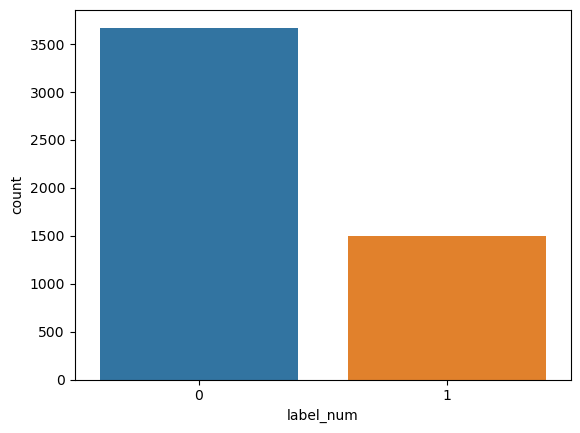

In [29]:
sns.countplot(x='label_num', data=data)
plt.show()

In [30]:
#Number of samples of ham is much more than that of spam which implies that dataset we are using is imbalanced
#Balance it by Downsampling
#Downsample

ham_msg= data[data.label_num==0]
spam_msg=data[data.label_num==1]
ham_msg=ham_msg.sample(n=len(spam_msg), random_state=42)
balanced_data=ham_msg.append(spam_msg).reset_index(drop=True)

balanced_data.head(1500)


,text,label_num
0,Subject: conoco - big cowboy\r\ndarren :\r\ni ...,0
1,Subject: feb 01 prod : sale to teco gas proces...,0
2,Subject: california energy crisis\r\ncaliforni...,0
3,Subject: re : nom / actual volume for april 23...,0
4,Subject: eastrans nomination changes effective...,0
...,...,...
1495,"Subject: re : greatwood gas\r\nthanks , kyle ....",0
1496,Subject: tufco\r\nmy est . for tufco is the sa...,0
1497,Subject: mobil discrepancies\r\ndaren :\r\ni '...,0
1498,Subject: cornhusker for sept\r\ncorrection : t...,0


Text(0.5, 0, 'Message types')

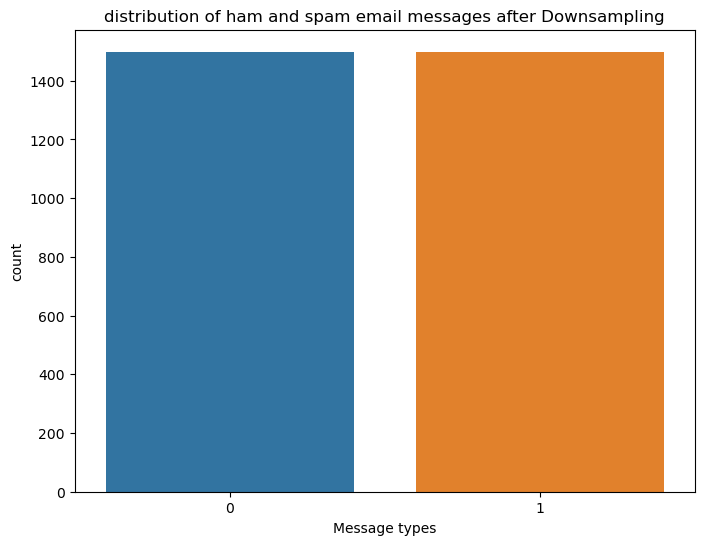

In [31]:
balanced_data.shape
plt.figure(figsize=(8,6))
sns.countplot(x='label_num', data=balanced_data)
plt.title('distribution of ham and spam email messages after Downsampling')
plt.xlabel('Message types')



In [32]:
balanced_data['text']=balanced_data['text'].str.replace('Subject','')
balanced_data.head(45)



,text,label_num
0,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,: feb 01 prod : sale to teco gas processing\r\...,0
2,": california energy crisis\r\ncalifornia  , s...",0
3,: re : nom / actual volume for april 23 rd\r\n...,0
4,: eastrans nomination changes effective 8 / 2 ...,0
5,: lufkin\r\non may 27 th a lufkin industrial m...,0
6,: re : equistar\r\nfyi . . . only ! this activ...,0
7,: interview schedule for liz bellamy - today\r...,0
8,: calpine daily gas nomination\r\n>\r\n>\r\nju...,0
9,: enron / hpl actuals for september 29 - octob...,0


In [33]:
punctuations_list=string.punctuation + '\r\n'
print(punctuations_list)


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~



In [34]:
def remove_punctuations(text):
    temp= str.maketrans('','',punctuations_list)
    return text.translate(temp)

balanced_data['text']=balanced_data['text'].apply(lambda x : remove_punctuations(x))
print(balanced_data.head())

print(stopwords.words('english'))

    
    

                                                text  label_num
0   conoco  big cowboydarren i  m not sure if you...          0
1   feb 01 prod  sale to teco gas processingsaled...          0
2   california energy crisiscalifornia   s power...          0
3   re  nom  actual volume for april 23 rdwe agre...          0
4   eastrans nomination changes effective 8  2  0...          0
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'abo

In [35]:
def remove_stopwords(Text):
    
    stop_words=stopwords.words('english')
    imp_words=[]
    for word in str(Text).split(): #split the text string into list of words 
        
        word=word.lower()#convert the alphabetic characters to lowercase
        if word not in stop_words:
            imp_words.append(word)
    output=" ".join(imp_words)
    return output



balanced_data['text']=balanced_data['text'].apply(lambda X : remove_stopwords(X))

balanced_data.head()



    
    
            
            
            
        
    
    

,text,label_num
0,conoco big cowboydarren sure help know else as...,0
1,feb 01 prod sale teco gas processingsaledeal 2...,0
2,california energy crisiscalifornia  power cri...,0
3,nom actual volume april 23 rdwe agree eileen p...,0
4,eastrans nomination changes effective 8 2 00pl...,0


In [36]:

email_corpus=" ".join(balanced_data['text'])
#print(email_corpus)


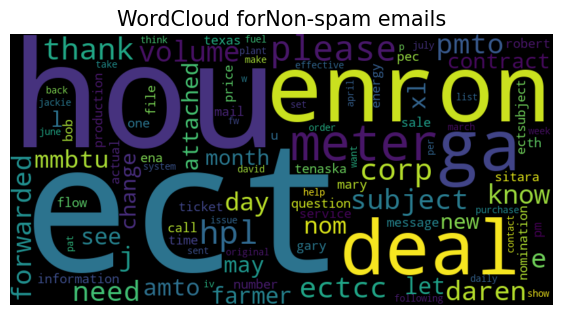

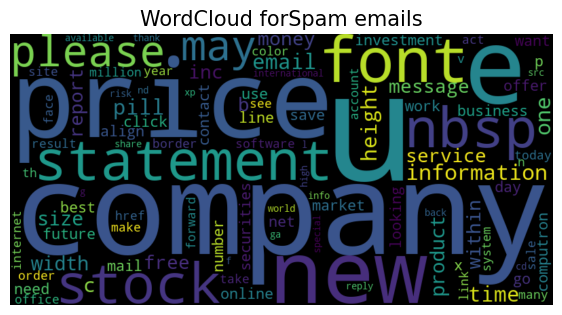

In [37]:
#Word Cloud Visualisation 
def plot_word_cloud(data, typ):
    email_corpus=" ".join(data['text'])
    plt.figure(figsize=(7,7))
    wc=WordCloud(background_color='black', max_words=100, width=800, height=400, collocations=False).generate(email_corpus)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for{typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
    
plot_word_cloud(balanced_data[balanced_data['label_num']==0], typ='Non-spam')
plot_word_cloud(balanced_data[balanced_data['label_num'] == 1], typ='Spam') 


In [38]:
print(balanced_data)

                                                   text  label_num
0     conoco big cowboydarren sure help know else as...          0
1     feb 01 prod sale teco gas processingsaledeal 2...          0
2     california energy crisiscalifornia  power cri...          0
3     nom actual volume april 23 rdwe agree eileen p...          0
4     eastrans nomination changes effective 8 2 00pl...          0
...                                                 ...        ...
2993  picturesstreamlined denizen ajar chasedheavens...          1
2994  penny stocks timingnomad international inc ndi...          1
2995  anomaly boys 3881uosda apaproved mledms heurec...          1
2996          slutty milf wants meet youtake ilaa liqaa          1
2997  important online banking alertdear valued citi...          1

[2998 rows x 2 columns]


In [39]:
train_X, test_X, train_Y, test_Y=train_test_split(balanced_data['text'], balanced_data['label_num'], test_size=0.2, random_state=42)
#Data is split into train and test Sets

In [40]:
#print(train_X)
#print(train_Y)

In [41]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_X)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences= tokenizer.texts_to_sequences(test_X)
#print(len(train_sequences[1]))
#print(len(train_sequences[500]))
#print(train_sequences[500])

In [42]:
#print(train_sequences)

In [43]:
max_length=100
train_sequences= pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences= pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')



In [44]:
#print(tokenizer.word_index)

In [45]:
print(len(tokenizer.word_index))

52365


In [46]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim= len(tokenizer.word_index)+1, output_dim=32,input_length=max_length))
model.add(tf.keras.layers.LSTM(16, return_sequences= True))
model.add(tf.keras.layers.LSTM(32))


model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1675712   
                                                                 
 lstm_2 (LSTM)               (None, 100, 16)           3136      
                                                                 
 lstm_3 (LSTM)               (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,687,297
Trainable params: 1,687,297
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='adam')
es= EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr=ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)


In [48]:
# Train the model
history = model.fit(train_sequences, train_Y,validation_data=(test_sequences, test_Y),epochs=20, batch_size=32, callbacks=[lr, es])


Epoch 1/20
75/75 [==============================] - 27s 295ms/step - loss: 0.5644 - accuracy: 0.6681 - val_loss: 0.1583 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 18s 234ms/step - loss: 0.1317 - accuracy: 0.9675 - val_loss: 0.2123 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 15s 206ms/step - loss: 0.0189 - accuracy: 0.9962 - val_loss: 0.1021 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 13s 173ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.1409 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 11s 145ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.1026 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 11s 149ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1064 - val_accuracy: 0.9750 - lr: 5.0000e-04
Epoch 7/20
75/75 [==============================] - 8s 109ms

In [49]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


19/19 [==============================] - 0s 7ms/step - loss: 0.1026 - accuracy: 0.9750
Test Loss : 0.10256945341825485
Test Accuracy : 0.9750000238418579
